# Clase 1: Introducción a Machine Learning
---

<img src="../img/sergio_portrait_square.png" alt="Sergio Benito" align="right" width="100">

- **Autor:** Sergio Benito Martín
- **Contacto:** pontia@sergiobenito.com
- **Última actualización:** 22/05/2025

### Objetivo
El objetivo de la clase es poder conocer tanto el ciclo de vida de un modelo de Machine Learning (será análogo en gran parte al campo del Deep Learning) así como varios de los conceptos relevantes a tener en cuenta.

### Temas a tratar

1. Metodología de ML con una Regresión Lineal Simple
2. Profundizar en la metodología entrando en una Regresión Lineal Múltiple
3. Validación mediante hold-out (*train-test split*)
4. Validación cruzada (*cross validation*)
5. Concepto de regularización
6. Introducción al ajuste de hiperparámetros

### Información útil
+ [Documentación oficial Regresión Lineal Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
+ [Documentación oficial Plotly](https://plotly.com/python/)
+ [Documentación oficial Plotly Regresión](https://plotly.com/python/ml-regression/)

---


## 0. Configuración del Notebook
Importaremos todas las librerías y funciones que vemos relevantes para el notebook que vamos a crear. Lo ideal sería tener todas las importaciones juntas, de tal manera que se puedan controlar de manera sencilla.

⚠️ Importante. Quizás sea necesario instalar las librerías `nbformat` y `statsmodels`, si se requiere ejecutar el siguiente comando con el entorno virtual activado:

```bash
uv pip install nbformat
uv pip install statsmodels
```

### Importación de librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

### Definición de constantes

In [2]:
PATH_DIRECTORIO_DATOS = "../data"

In [3]:
PATH_DATASET_ADVERTISING = f"{PATH_DIRECTORIO_DATOS}/advertising.csv"
PATH_DATASET_CALORIES = f"{PATH_DIRECTORIO_DATOS}/calories.csv"
PATH_DATASET_CALORIES_LITE = f"{PATH_DIRECTORIO_DATOS}/calories_time_reduc.csv"
PATH_DATASET_CALORIES_TIME = f"{PATH_DIRECTORIO_DATOS}/calories_time.csv"
PATH_DATASET_HEART = f"{PATH_DIRECTORIO_DATOS}/heart_disease.csv"
PATH_DATASET_BOSTON = f"{PATH_DIRECTORIO_DATOS}/housing_boston.csv"
PATH_DATASET_TWEETS = f"{PATH_DIRECTORIO_DATOS}/nlp_tweets.csv"

### Definición de funciones

In [4]:
# Calculamos las métricas de evaluación
def calcular_metricas_evaluacion(y_prediccion: np.ndarray, y_real: np.ndarray, verbose: bool = True):
    """Calcula las métricas de evaluación para un modelo de regresión.
    
    Calcula cuatro métricas comunes para evaluar modelos de regresión: MSE (Error Cuadrático Medio),
    RMSE (Raíz del Error Cuadrático Medio), MAE (Error Absoluto Medio) y R² (Coeficiente de determinación).
    Opcionalmente imprime los resultados en un formato legible.
    
    Args:
        y_prediccion (np.ndarray): Valores predichos por el modelo.
        y_real (np.ndarray): Valores reales observados.
        verbose (bool, optional): Si es True, imprime las métricas calculadas. Por defecto es True.
    
    Returns:
        tuple[float, float, float, float]: Una tupla con cuatro valores en el siguiente orden:
            - mse: Error cuadrático medio.
            - rmse: Raíz del error cuadrático medio.
            - mae: Error absoluto medio.
            - r2: Coeficiente de determinación.
    
    Example:
        >>> mse, rmse, mae, r2 = calcular_metricas_evaluacion(modelo.predict(X_test), y_test)
        >>> print(f"R²: {r2:.4f}")
    """
    
    mse = mean_squared_error(y_real, y_prediccion)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_real, y_prediccion)
    r2 = r2_score(y_real, y_prediccion)

    if verbose:
        print("\nEvaluación del modelo:")
        print(f"MSE (Error cuadrático medio): {mse:.4f}")
        print(f"RMSE (Raíz del error cuadrático medio): {rmse:.4f}")
        print(f"MAE (Error absoluto medio): {mae:.4f}")
        print(f"R² (Coeficiente de determinación): {r2:.4f}")
        print(f"El modelo explica aproximadamente el {r2:.2%} de la varianza")
    
    return mse, rmse, mae, r2

def plot_regresion_lineal_interactiva(df: pd.DataFrame, variable_independiente: str, variable_dependiente: str, modelo: LinearRegression, titulo: str = "Regresión Lineal", xaxis_titulo: str = "X", yaxis_titulo: str = "Y") -> go.Figure:
    """Genera un gráfico interactivo de regresión lineal usando Plotly.
    
    Crea una visualización interactiva que muestra los datos originales como puntos y la línea
    de regresión lineal ajustada. También muestra la ecuación del modelo y las métricas de evaluación
    (MSE, RMSE, MAE, R²) en anotaciones sobre el gráfico.
    
    Args:
        df (pd.DataFrame): DataFrame que contiene los datos para visualizar.
        variable_independiente (str): Nombre de la columna con la variable independiente (X).
        variable_dependiente (str): Nombre de la columna con la variable dependiente (Y).
        modelo (LinearRegression): Modelo de regresión lineal previamente entrenado.
        titulo (str, optional): Título del gráfico. Por defecto es "Regresión Lineal".
        xaxis_titulo (str, optional): Título del eje X. Por defecto es "X".
        yaxis_titulo (str, optional): Título del eje Y. Por defecto es "Y".
    
    Returns:
        go.Figure: Objeto Figure de Plotly que puede ser mostrado con .show() o 
                   incluido en un dashboard.
    
    Example:
        >>> modelo = LinearRegression()
        >>> modelo.fit(df[["tiempo"]], df["ventas"])
        >>> fig = plot_regresion_lineal_interactiva(
        ...     df, 
        ...     variable_independiente="tiempo",
        ...     variable_dependiente="ventas",
        ...     modelo=modelo,
        ...     titulo="Ventas vs Tiempo",
        ...     xaxis_titulo="Tiempo (días)",
        ...     yaxis_titulo="Ventas ($)"
        ... )
        >>> fig.show()
    """
    
    # Calcular las métricas de evaluación
    X = df[[variable_independiente]]
    y = df[variable_dependiente]
    
    y_pred = modelo.predict(X)
    mse, rmse, mae, r2 = calcular_metricas_evaluacion(y_pred, y, verbose=False)

    # Crear la figura
    fig = go.Figure()

    # Añadir los puntos de datos
    fig.add_trace(
        go.Scatter(
            x=df[variable_independiente], 
            y=df[variable_dependiente],
            mode='markers',
            name='Datos reales',
            marker=dict(color='blue', size=8, opacity=0.6)
        )
    )

    # Añadir la línea de regresión
    fig.add_trace(
        go.Scatter(
            x=df[variable_independiente], 
            y=y_pred,
            mode='lines',
            name='Regresión lineal',
            line=dict(color='red', width=2)
        )
    )

    # Coeficientes del modelo
    coeficiente = modelo.coef_[0]
    intercepto = modelo.intercept_

    # Ecuación y métricas para mostrar en el gráfico
    equation_text = f"Ecuación: y = {coeficiente:.4f} × x + {intercepto:.4f}"
    metrics_text = f"MSE: {mse:.2f}, RMSE: {rmse:.2f}<br>MAE: {mae:.2f}, R²: {r2:.4f}"

    # Añadir anotaciones
    fig.add_annotation(
        x=0.02,
        y=0.98,
        xref="paper",
        yref="paper",
        text=equation_text,
        showarrow=False,
        font=dict(size=14),
        align="left",
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1
    )

    fig.add_annotation(
        x=0.02,
        y=0.90,
        xref="paper",
        yref="paper",
        text=metrics_text,
        showarrow=False,
        font=dict(size=12),
        align="left",
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1
    )

    # Configuración del diseño
    fig.update_layout(
        title=titulo,
        xaxis_title=xaxis_titulo,
        yaxis_title=yaxis_titulo,
        legend=dict(x=0.02, y=0.02),
        plot_bgcolor='white',
        width=900,
        height=600
    )

    # Añadir cuadrícula
    fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')

    return fig

In [5]:
def plot_residuos(y_pred: np.ndarray, y_true: np.ndarray):
    """Genera un gráfico de dispersión de los residuos vs valores predichos.
    
    Este gráfico permite identificar patrones no aleatorios en los residuos que podrían
    indicar problemas con el modelo como heteroscedasticidad o no linealidad.
    
    Args:
        y_pred (np.ndarray): Valores predichos por el modelo.
        y_true (np.ndarray): Valores reales observados.
    
    Returns:
        None: Muestra el gráfico directamente.
    
    Example:
        >>> plot_residuos(model.predict(X), y)
    """    
    residuos = y_true - y_pred

    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuos, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Valores predichos')
    plt.ylabel('Residuos')
    plt.title('Residuos vs. Valores Predichos')
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_histograma_residuos(y_pred: np.ndarray, y_true: np.ndarray):
    """Genera un histograma de los residuos del modelo.
    
    Permite evaluar la distribución de los residuos, idealmente debería
    aproximarse a una distribución normal centrada en cero.
    
    Args:
        y_pred (np.ndarray): Valores predichos por el modelo.
        y_true (np.ndarray): Valores reales observados.
    
    Returns:
        None: Muestra el gráfico directamente.
    
    Example:
        >>> plot_histograma_residuos(model.predict(X), y)
    """
    residuos = y_true - y_pred

    plt.figure(figsize=(10, 6))
    plt.hist(residuos, bins=15, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(x=0, color='r', linestyle='-')
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Residuos')
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_qq_plot_residuos(y_pred: np.ndarray, y_true: np.ndarray):
    """Genera un gráfico Q-Q (quantile-quantile) para evaluar la normalidad de los residuos.
    
    Compara los cuantiles de los residuos con los cuantiles teóricos de una
    distribución normal. Si los puntos siguen aproximadamente la línea diagonal,
    sugiere que los residuos siguen una distribución normal.
    
    Args:
        y_pred (np.ndarray): Valores predichos por el modelo.
        y_true (np.ndarray): Valores reales observados.
    
    Returns:
        None: Muestra el gráfico directamente.
    
    Example:
        >>> plot_qq_plot_residuos(model.predict(X), y)
    """
    residuos = y_true - y_pred
    plt.figure(figsize=(10, 6))
    stats.probplot(residuos, dist="norm", plot=plt)
    plt.title('Q-Q Plot de Residuos')
    plt.grid(True, alpha=0.3)
    plt.show()


def resumen_estadistico_residuos(y_pred: np.ndarray, y_true: np.ndarray, verbose=True) -> dict:
    """Calcula estadísticas descriptivas de los residuos del modelo.
    
    Genera un resumen estadístico con métricas básicas como media, desviación estándar,
    valores mínimo y máximo de los residuos.
    
    Args:
        y_pred (np.ndarray): Valores predichos por el modelo.
        y_true (np.ndarray): Valores reales observados.
        verbose (bool, optional): Si es True, imprime las estadísticas. Por defecto es True.
    
    Returns:
        dict: Diccionario con las estadísticas calculadas:
            - 'media': Media aritmética de los residuos.
            - 'desviacion_estandar': Desviación estándar de los residuos.
            - 'minimo': Valor mínimo de los residuos.
            - 'maximo': Valor máximo de los residuos.
    
    Example:
        >>> stats = resumen_estadistico_residuos(model.predict(X), y)
        >>> print(f"Desviación estándar: {stats['desviacion_estandar']:.4f}")
    """
    residuos = y_true - y_pred
    resumen = {
        'media': residuos.mean(),
        'desviacion_estandar': residuos.std(),
        'minimo': residuos.min(),
        'maximo': residuos.max()
    }
    if verbose:
        print("Resumen estadístico de los residuos:")
        print(f"Media: {resumen['media']:.4f}")
        print(f"Desviación estándar: {resumen['desviacion_estandar']:.4f}")
        print(f"Mínimo: {resumen['minimo']:.4f}")
        print(f"Máximo: {resumen['maximo']:.4f}")
    return resumen

In [6]:
def plot_matriz_correlacion(df: pd.DataFrame, variable_dependiente:str):
    """Genera una matriz de correlación interactiva utilizando Plotly.
    
    Crea una visualización de mapa de calor que muestra las correlaciones entre todas
    las variables numéricas del DataFrame, con anotaciones de los valores exactos.
    Adicionalmente, imprime un ranking de correlaciones con la variable dependiente
    especificada.
    
    Args:
        df (pd.DataFrame): DataFrame que contiene las variables numéricas para analizar.
        variable_dependiente (str): Nombre de la columna que se considera la variable dependiente,
                                   cuyas correlaciones se mostrarán ordenadas.
    
    Returns:
        None: Muestra el gráfico interactivo con Plotly y una tabla de correlaciones
              con la variable dependiente en la consola.
    
    Example:
        >>> plot_matriz_correlacion(df_calories, "calories")
    """
    
    # Crear matriz de correlación para visualizar relaciones entre variables con Plotly
    correlation_matrix = df.corr()

    # Crear un mapa de calor interactivo con Plotly
    fig = px.imshow(
        correlation_matrix,
        text_auto='.2f',                    # Mostrar valores numéricos con 2 decimales
        color_continuous_scale='RdBu_r',    # Esquema de colores (rojo-blanco-azul invertido)
        zmin=-1, zmax=1,                    # Rango de valores
        aspect="auto",                      # Ajustar aspecto automáticamente
        title='Matriz de Correlación entre Variables'
    )

    # Mejorar el diseño
    fig.update_layout(
        width=800, 
        height=700,
        coloraxis_colorbar=dict(
            title="Coeficiente<br>de Correlación",
            thicknessmode="pixels", thickness=20,
            lenmode="pixels", len=500,
            yanchor="top", y=1,
            ticks="outside"
        ),
        font=dict(size=12),
    )

    # Identificar y mostrar las correlaciones más fuertes con 'calories'
    correlaciones_con_calories = correlation_matrix[variable_dependiente].sort_values(ascending=False)

    # Mostrar el gráfico interactivo
    fig.show()

    # Imprimir correlaciones con 'calories'
    print(f"\nCorrelaciones con '{variable_dependiente}':")
    print(correlaciones_con_calories)

## 1. Creación de un modelo de Regresión Lineal Simple
Veremos los pasos necesarios para crear un modelo sencillo de regresión, pasando por todas las etapas necesarias.

$$\hat{y} = \beta_0 + \beta_1 x  + ε $$

Donde:
- $\hat{y}$ es el valor predicho (calorías estimadas)
- $\beta_0$ es el término independiente o intercepto (coeficiente que indica el valor de y cuando x es 0)
- $\beta_1$ es el coeficiente o pendiente (indica cuánto cambia y por cada unidad de cambio en x)
- $x$ es nuestra variable independiente (tiempo de ejercicio)
- $ε$ es el error que tiene el modelo

Esta fórmula representa una línea recta que intentará aproximarse lo mejor posible a nuestros datos, minimizando la suma de los errores cuadráticos.

### Lectura de datos
Utilizaremos la librería Pandas para leer y manipular datos, leyendo un archivo de datos denominado *"dataset"* e instanciando una variable con esta información que llamaremos *Dataframe*.

In [7]:
df_calories_lite = pd.read_csv(PATH_DATASET_CALORIES_LITE)

### Comprobación y preprocesamiento de datos
Veremos cuáles son los datos que tenemos en el Dataframe, si los tipos asignados tienen sentido, descriptivo estadístico de las columnas, etc

In [8]:
# Mostrar las primeras filas del DataFrame
df_calories_lite.head()

,Calories,Time
0,0.0,0.0
1,177.9,13.7
2,644.1,51.9
3,929.4,55.4
4,941.2,61.9


In [9]:
# Mostrar las dimensiones del DataFrame
df_calories_lite.shape

(74, 2)

In [10]:
# Mostrar información del DataFrame
df_calories_lite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Calories  74 non-null     float64
 1   Time      74 non-null     float64
dtypes: float64(2)
memory usage: 1.3 KB


In [11]:
# Descripción estadística de las columnas numéricas. Recomendación el usar .transpose() para ver el listado de variables
df_calories_lite.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Calories,74.0,584.536486,287.050136,0.0,346.70,609.65,811.875,1201.2
Time,74.0,38.400000,20.048175,0.0,22.05,36.20,51.900,87.8


In [12]:
# Recomendado tener todos los nombres de las variables en minúsculas
df_calories_lite.columns = df_calories_lite.columns.str.lower()

In [13]:
# Verificar si hay valores nulos en el DataFrame
df_calories_lite

,calories,time
0,0.0,0.0
1,177.9,13.7
2,644.1,51.9
3,929.4,55.4
4,941.2,61.9
...,...,...
69,879.5,43.7
70,907.5,66.8
71,212.0,8.7
72,215.7,15.2


In [14]:
# Verificar si hay valores duplicados en el DataFrame
df_calories_lite.isna().sum()

calories    0
time        0
dtype: int64

In [15]:
df_calories_lite.duplicated()

0     False
1     False
2     False
3     False
4     False
      ...  
69    False
70    False
71    False
72    False
73    False
Length: 74, dtype: bool

<Axes: xlabel='calories', ylabel='Count'>

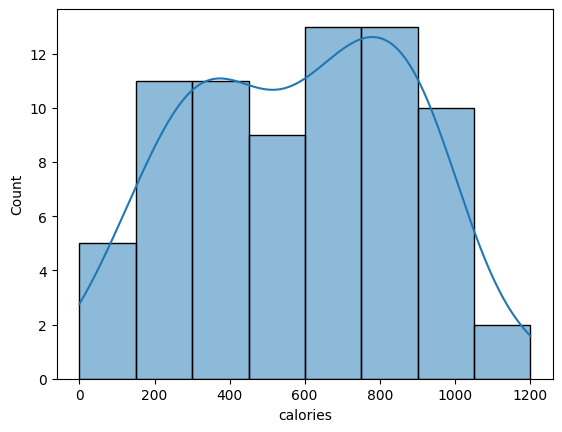

In [16]:
# Visualización de la distribución de la variable "calories" usando seaborn
sns.histplot(data=df_calories_lite, x="calories", kde=True)

<Axes: xlabel='time', ylabel='Count'>

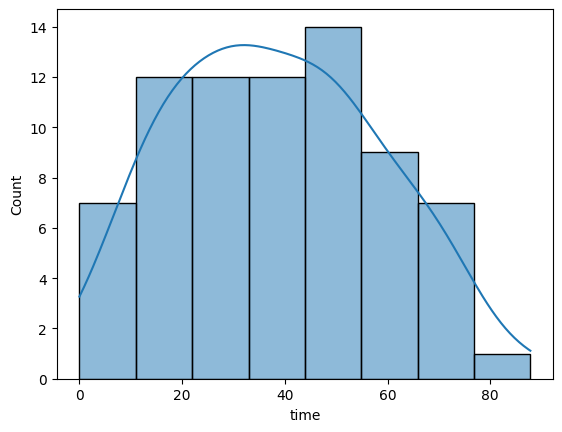

In [17]:
# Visualización de la distribución de la variable "time" usando seaborn
sns.histplot(data=df_calories_lite, x="time", kde=True)

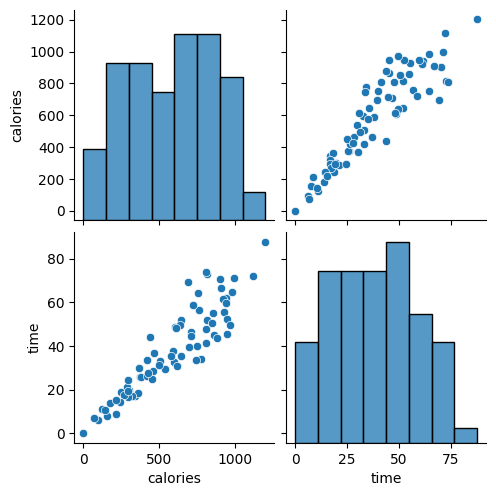

In [18]:
# Visualización de la relación entre "calories" y "time" usando seaborn
sns.pairplot(df_calories_lite)

In [19]:
fig = px.scatter(data_frame=df_calories_lite, x="time", y="calories", title="Relación entre Tiempo y Calorías")

fig.show(renderer='iframe')

### Creación del modelo (hipótesis y ajuste)
+ Utilizaremos la variable independiente `time` para ajustar un modelo de regresión lineal usando la clase `LinearRegression()` de la librería `sklearn`.
+ Para ello, ajustaremos (o entrearemos) el modelo (o hipótesis) gracias al método `.fit(variables_independientes, variable_dependiente)`, donde nuestras variable independiente la llaremos (pueden ser varias en otros casos de uso) `X` y la dependiente la denominaremos como `y`.

```python
# Importar la clase LinearRegression de sklearn
from sklearn.linear_model import LinearRegression
```

In [20]:
# Preparación de los datos para el modelo de regresión lineal
X = df_calories_lite[["time"]]
y = df_calories_lite["calories"]

In [21]:
# Creación del modelo de regresión lineal
modelo_simple = LinearRegression()

In [22]:
# Coeficientes del modelo
modelo_simple.fit(X, y)

LinearRegression()

In [23]:
coeficiente = modelo_simple.coef_

In [24]:
intercepto = modelo_simple.intercept_

In [25]:
print(f"La fórmula de la regresión lineal es: y = {coeficiente} * x + {intercepto}")
print(f"O lo que es lo mismo: calories = {coeficiente} * time + {intercepto}")

La fórmula de la regresión lineal es: y = [13.06477899] * x + 82.84897324555669
O lo que es lo mismo: calories = [13.06477899] * time + 82.84897324555669


### Visualización de la recta y evaluación del modelo
En esta sección, implementaremos código para visualizar gráficamente nuestro modelo de regresión lineal y evaluar su rendimiento con métricas cuantitativas. Este es un paso crucial después de entrenar el modelo para entender cómo se ajusta a los datos. Usar las siguientes funciones de `sklearn`:

```python
# Importamos las métricas necesarias para evaluar el modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
```

In [26]:
# Realizamos predicciones con el modelo
y_pred = modelo_simple.predict(X)
y_pred

array([  82.84897325,  261.83644542,  760.91100286,  806.63772933,
        891.55879277,  342.83807516,  303.64373819,  421.2267491 ,
        456.50165238,  321.93442877, 1014.36771528,  418.61379331,
        691.66767421,  800.10533983,  513.98667994, 1035.27136166,
        225.25506424,  528.35793683, 1229.93656862,  719.10371009,
        304.95021609,  329.77329617,  823.62194202,  768.74987025,
        184.75424937,  576.69761909,  545.34214951,  729.55553328,
        426.4526607 ,  606.74661077,  359.82228785, 1026.12601637,
       1005.22236999,  712.57132059,  665.53811623,  656.39277094,
        520.51906943,  510.06724624,  469.56643137,  476.09882086,
        544.03567162,  760.91100286,  704.7324532 ,  406.85549221,
        566.2457959 ,  301.03078239,  677.29641732,  601.52069917,
        989.5446352 ,  220.02915265,  310.17612768,  519.21259153,
        625.03730136,  732.16848908,  485.24416616,  745.23326807,
        163.85060299,  925.52721814,  268.36883491, 1049.64261

In [27]:
# Calculamos las métricas de evaluación
mse = calcular_metricas_evaluacion(y_pred, y, verbose=False)[0]
rmse = calcular_metricas_evaluacion(y_pred, y, verbose=False)[1]
mae = calcular_metricas_evaluacion(y_pred, y, verbose=False)[2]
r2 = calcular_metricas_evaluacion(y_pred, y, verbose=False)[3]

In [28]:
mse

13606.695783815261

In [29]:
rmse

116.64774230054888

In [30]:
mae

92.40392091643383

In [31]:
r2

0.8326036361819392

In [32]:
# Imprimir las métricas
print("\nEvaluación del modelo:")
print(f"MSE (Error cuadrático medio): {mse:.4f}")
print(f"RMSE (Raíz del error cuadrático medio): {rmse:.4f}")
print(f"MAE (Error absoluto medio): {mae:.4f}")
print(f"R² (Coeficiente de determinación): {r2:.4f}")
print(f"El modelo explica aproximadamente el {r2:.2%} de la varianza en las calorías quemadas")


Evaluación del modelo:
MSE (Error cuadrático medio): 13606.6958
RMSE (Raíz del error cuadrático medio): 116.6477
MAE (Error absoluto medio): 92.4039
R² (Coeficiente de determinación): 0.8326
El modelo explica aproximadamente el 83.26% de la varianza en las calorías quemadas


In [33]:
_, _, _, _=calcular_metricas_evaluacion(y_pred, y)


Evaluación del modelo:
MSE (Error cuadrático medio): 13606.6958
RMSE (Raíz del error cuadrático medio): 116.6477
MAE (Error absoluto medio): 92.4039
R² (Coeficiente de determinación): 0.8326
El modelo explica aproximadamente el 83.26% de la varianza


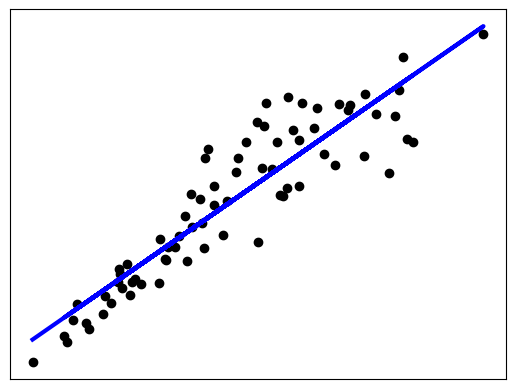

In [34]:
# Plot outputs
plt.scatter(X, y,  color='black')
plt.plot(X, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [35]:
plot_regresion_lineal_interactiva(
    df_calories_lite,
    variable_independiente="time",
    variable_dependiente="calories",
    modelo=modelo_simple, titulo="Regresión Lineal: Calorías vs Tiempo",
    xaxis_titulo="Tiempo (minutos)",
    yaxis_titulo="Calorías quemadas"
).show(renderer='iframe')

In [36]:
# Graficar los residuos usando plotly permite de manera muy sencilla dibujar la recta de regresión usando Ordinary Least Squares (OLS)
fig = px.scatter(data_frame=df_calories_lite, x="time", y="calories", title="Relación entre Tiempo y Calorías", trendline="ols")
fig.show(renderer="iframe")

### Residuos del modelo
El análisis de residuos es una parte fundamental para evaluar la calidad de un modelo de regresión. Los residuos son las diferencias entre los valores observados y los valores predichos por el modelo:

$$\text{Residuo} = y_{\text{real}} - y_{\text{predicho}}$$

Tres gráficos relevantes:
1. Residuos vs. Valores Predichos:
    + Patrón ideal: Puntos dispersos aleatoriamente alrededor de la línea horizontal `y = 0`.
    + Qué buscar: Patrones como curvas, cónicos (heteroscedasticidad) o agrupaciones, que indicarían problemas con el modelo.
2. Histograma de Residuos:
    + Patrón ideal: Distribución aproximadamente normal centrada en cero.
    + Qué buscar: Sesgo (asimetría) o valores atípicos que podrían indicar problemas con el modelo.
3. QQ-Plot:
    + Patrón ideal: Puntos que siguen aproximadamente la línea diagonal.
    + Qué buscar: Desviaciones de la línea diagonal, especialmente en los extremos, que indicarían no normalidad.

Utilizar las funciones declaradas en el apartado superior del notebook:

```python
plot_residuos(y_pred=y_pred, y_true=y)

plot_histograma_residuos(y_pred=y_pred, y_true=y)

plot_qq_plot_residuos(y_pred=y_pred, y_true=y)

_ = resumen_estadistico_residuos(y_pred=y_pred, y_true=y, verbose=True)
```

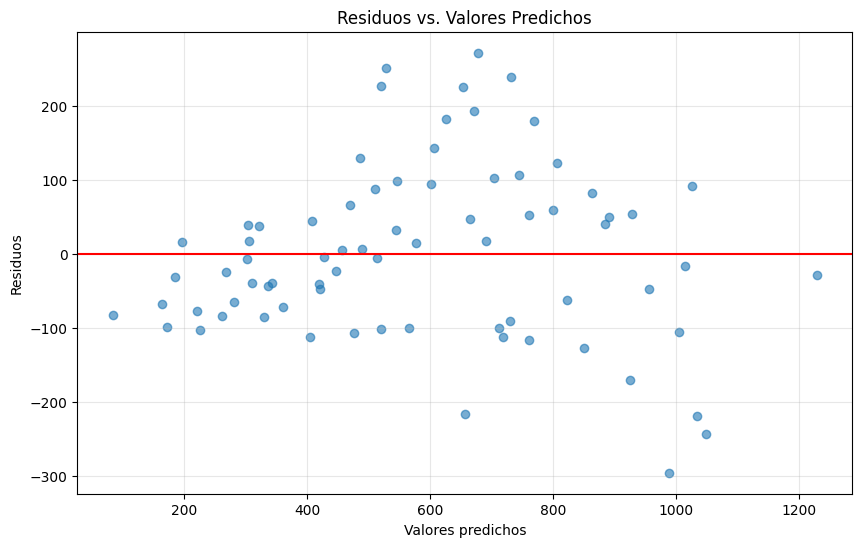

In [37]:
plot_residuos(y_pred=y_pred, y_true=y)

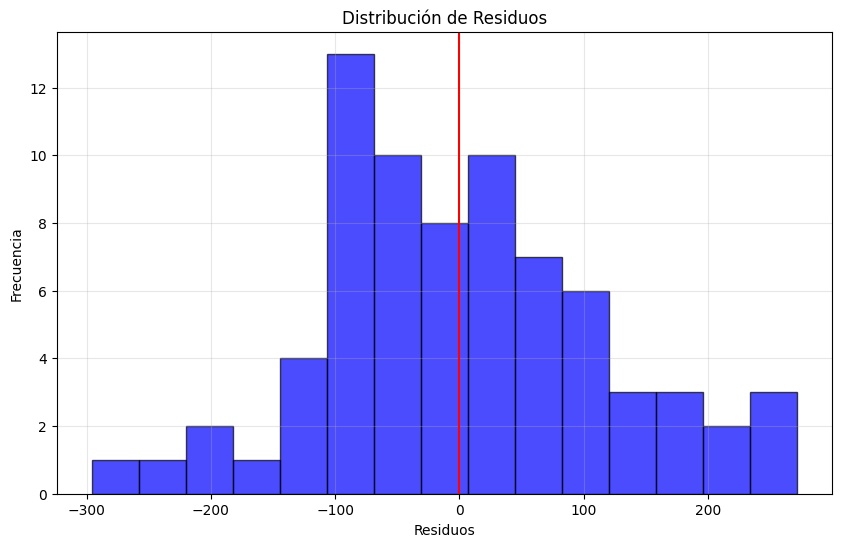

In [38]:
plot_histograma_residuos(y_pred=y_pred, y_true=y)

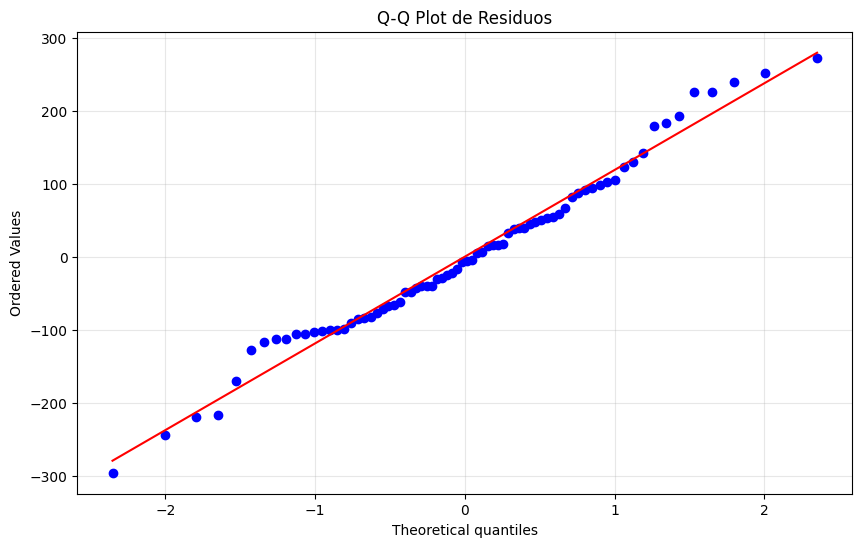

In [39]:
plot_qq_plot_residuos(y_pred=y_pred, y_true=y)

In [40]:
resumen_estadistico_residuos(y_pred=y_pred, y_true=y, verbose=True)

Resumen estadístico de los residuos:
Media: -0.0000
Desviación estándar: 117.4440
Mínimo: -295.6446
Máximo: 271.4036


{'media': -5.377080162508866e-14,
 'desviacion_estandar': 117.44398186686382,
 'minimo': -295.6446351966123,
 'maximo': 271.40358267990405}

## 2. Regresión Lineal Múltiple
La Regresión Lineal Múltiple extiende el concepto de la regresión lineal simple para incluir más de una variable independiente, lo que permite construir modelos más completos y precisos.

$$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n  + ε $$

### Lectura de datos
Utilizaremos la librería Pandas para leer y manipular datos, leyendo un archivo de datos denominado *"dataset"* e instanciando una variable con esta información que llamaremos *Dataframe*.

In [41]:
df_calories = pd.read_csv(PATH_DATASET_CALORIES)

### Lectura de datos
Utilizaremos la librería Pandas para leer y manipular datos, leyendo un archivo de datos denominado *"dataset"* e instanciando una variable con esta información que llamaremos *Dataframe*.

In [42]:
# Mostrar las primeras filas
df_calories

,Calorias,Tiempo,Peso,Velocidad
0,177.9,13.7,61.2,12.3
1,644.1,51.9,62.6,11.5
2,929.4,55.4,69.3,14.0
3,941.2,61.9,80.1,11.0
4,303.1,19.9,95.6,9.2
...,...,...,...,...
4995,1180.7,69.3,93.7,10.5
4996,1183.0,56.9,77.9,15.5
4997,341.2,31.3,60.1,10.5
4998,149.7,11.3,83.6,9.2


In [43]:
# Mostrar los tipos de las variables
df_calories.info

<bound method DataFrame.info of       Calorias  Tiempo  Peso  Velocidad
0        177.9    13.7  61.2       12.3
1        644.1    51.9  62.6       11.5
2        929.4    55.4  69.3       14.0
3        941.2    61.9  80.1       11.0
4        303.1    19.9  95.6        9.2
...        ...     ...   ...        ...
4995    1180.7    69.3  93.7       10.5
4996    1183.0    56.9  77.9       15.5
4997     341.2    31.3  60.1       10.5
4998     149.7    11.3  83.6        9.2
4999     622.4    37.4  77.0       12.5

[5000 rows x 4 columns]>

In [44]:
# Mostrar los descriptivos de las variables
df_calories.describe()

,Calorias,Tiempo,Peso,Velocidad
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,579.695640,39.364560,70.101200,12.503720
std,310.379773,21.433103,9.982623,2.038588
min,58.500000,3.900000,32.500000,9.000000
25%,313.775000,21.200000,63.500000,10.700000
50%,565.350000,38.000000,70.100000,12.500000
75%,820.100000,55.200000,76.800000,14.300000
max,1487.600000,99.600000,104.100000,16.000000


In [45]:
# Verificar si hay valores nulos en el DataFrame
df_calories.isna().sum()

Calorias     0
Tiempo       0
Peso         0
Velocidad    0
dtype: int64

In [46]:
# Transformar los nombres de las columnas a minúsculas
df_calories.columns = df_calories.columns.str.lower()

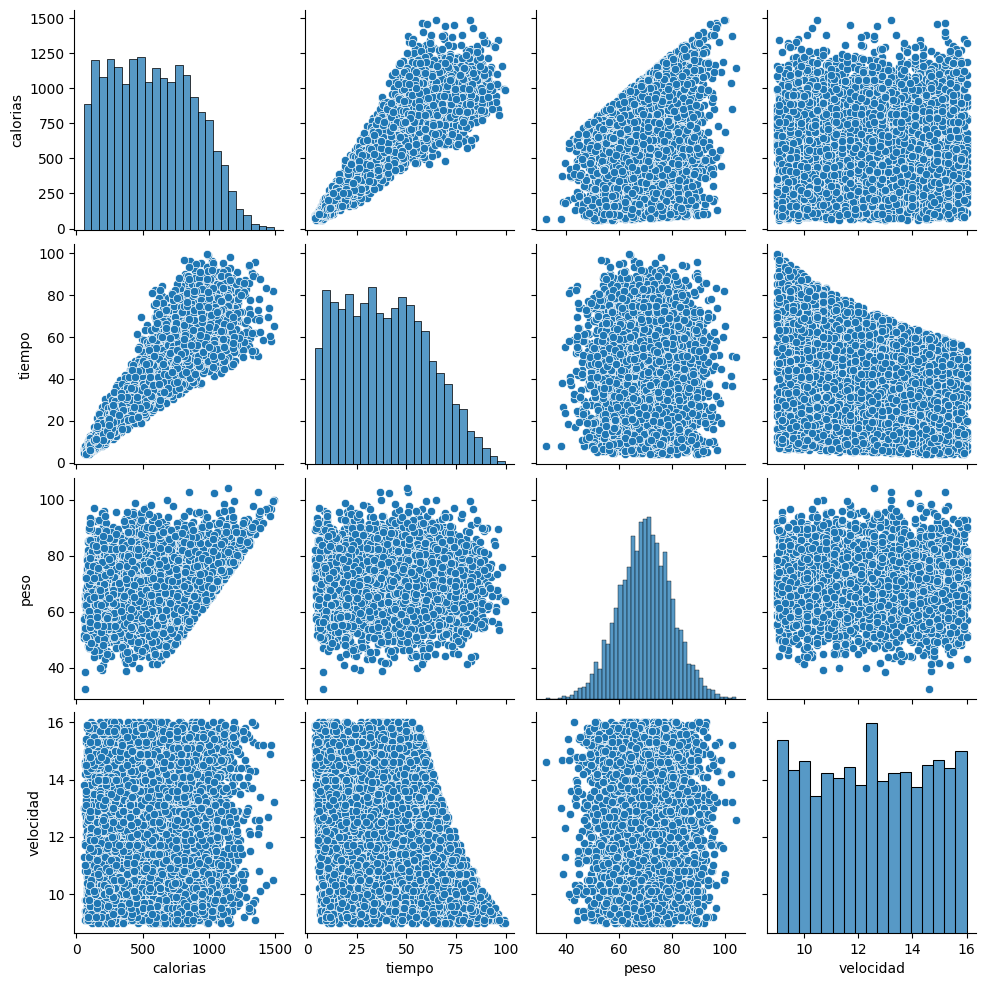

In [47]:
# Visualización de la relación entre "calories" y "time" usando seaborn
sns.pairplot(df_calories)

In [48]:
plot_matriz_correlacion(df_calories, "calorias")


Correlaciones con 'calorias':
calorias     1.000000
tiempo       0.892129
peso         0.263631
velocidad    0.008829
Name: calorias, dtype: float64


### Creación del modelo (hipótesis y ajuste)

In [49]:
df_calories

,calorias,tiempo,peso,velocidad
0,177.9,13.7,61.2,12.3
1,644.1,51.9,62.6,11.5
2,929.4,55.4,69.3,14.0
3,941.2,61.9,80.1,11.0
4,303.1,19.9,95.6,9.2
...,...,...,...,...
4995,1180.7,69.3,93.7,10.5
4996,1183.0,56.9,77.9,15.5
4997,341.2,31.3,60.1,10.5
4998,149.7,11.3,83.6,9.2


In [50]:
# Preparación de los datos para el modelo de regresión lineal
X = df_calories.drop(columns="calorias")
y = df_calories["calorias"]

In [51]:
modelo_reg_mul = LinearRegression()
modelo_reg_mul.fit(X, y)

LinearRegression()

In [52]:
# Coeficientes del modelo
coeficientes = modelo_reg_mul.coef_
intercept = modelo_reg_mul.intercept_

In [53]:
for i in range(len(X.columns)):
    print(f"Coeficiente para {X.columns[i]}: {coeficientes[i]:.4f}")

Coeficiente para tiempo: 14.2628
Coeficiente para peso: 8.5543
Coeficiente para velocidad: 46.6605


In [54]:
formula = f"calorias = {intercept:.4f} + " + " + ".join([f"{coef:.4f} * {col}" for coef, col in zip(coeficientes, X.columns)])
formula

'calorias = -1164.8477 + 14.2628 * tiempo + 8.5543 * peso + 46.6605 * velocidad'

### Evaluación del modelo
Al ser una regresión lineal múltiple no se podría visualizar en 2 dimensiones a diferencia del ejercicio anterior, entonces solamente se obtendrán las métricas de evaluación.

In [55]:
y_pred = modelo_reg_mul.predict(X)
y_pred

array([127.9992125 , 647.48389963, 871.36857476, ..., 285.62499799,
       140.73741519, 610.51644355])

In [56]:
mse, rmse, mae, r2 = calcular_metricas_evaluacion(y_pred, y)


Evaluación del modelo:
MSE (Error cuadrático medio): 4439.9687
RMSE (Raíz del error cuadrático medio): 66.6331
MAE (Error absoluto medio): 48.2005
R² (Coeficiente de determinación): 0.9539
El modelo explica aproximadamente el 95.39% de la varianza


### Residuos del modelo
El análisis de residuos es una parte fundamental para evaluar la calidad de un modelo de regresión. Los residuos son las diferencias entre los valores observados y los valores predichos por el modelo:

$$\text{Residuo} = y_{\text{real}} - y_{\text{predicho}}$$

Tres gráficos relevantes:
1. Residuos vs. Valores Predichos:
    + Patrón ideal: Puntos dispersos aleatoriamente alrededor de la línea horizontal `y = 0`.
    + Qué buscar: Patrones como curvas, cónicos (heteroscedasticidad) o agrupaciones, que indicarían problemas con el modelo.
2. Histograma de Residuos:
    + Patrón ideal: Distribución aproximadamente normal centrada en cero.
    + Qué buscar: Sesgo (asimetría) o valores atípicos que podrían indicar problemas con el modelo.
3. QQ-Plot:
    + Patrón ideal: Puntos que siguen aproximadamente la línea diagonal.
    + Qué buscar: Desviaciones de la línea diagonal, especialmente en los extremos, que indicarían no normalidad.

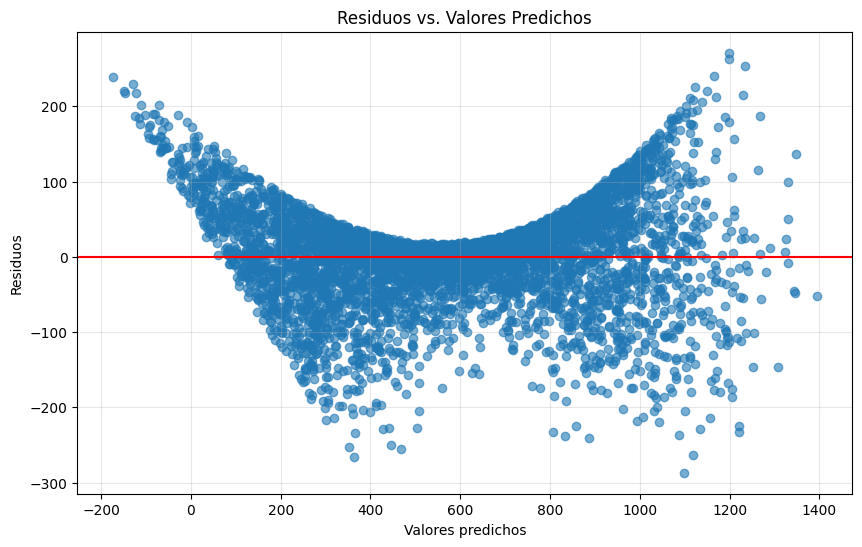

In [57]:
plot_residuos(y_pred=y_pred, y_true=y)

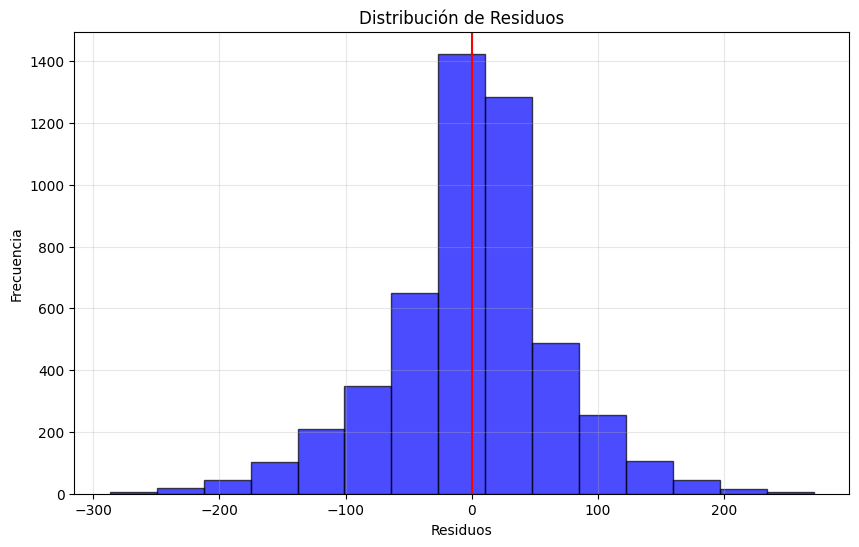

In [58]:
plot_histograma_residuos(y_pred=y_pred, y_true=y)

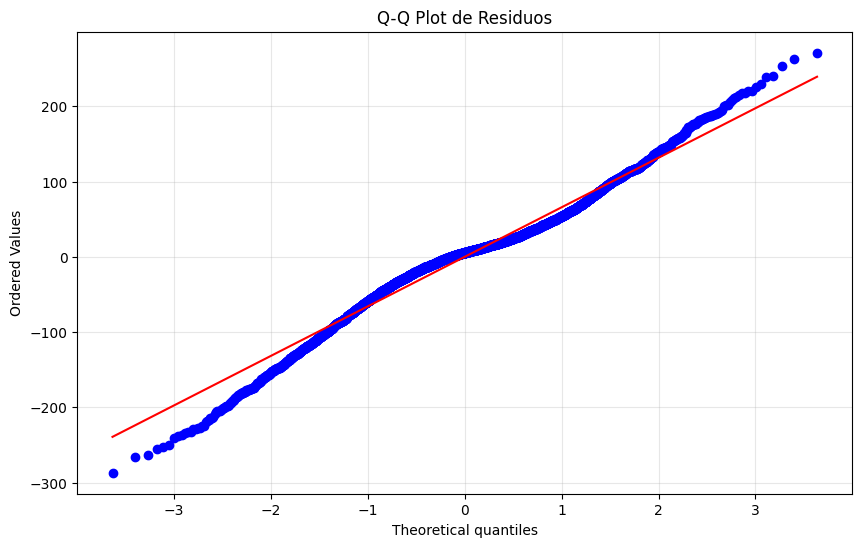

In [59]:
plot_qq_plot_residuos(y_pred=y_pred, y_true=y)

### Ejercicio: Crear una regresión lineal múltiple con Boston
Usando el dataset de Boston prices, utilizando la variable `MEDV` como target, entrenar un modelo de regresión lineal múltiple con las variables que se deseen.

Aquí un listado de las variables del dataset y su descripción:

| Variable | Descripción | Tipo de Dato |
|----------|-------------|---------------|
| CRIM     | Tasa de criminalidad per cápita por ciudad | Numérico continuo |
| ZN       | Proporción de terrenos residenciales para lotes mayores de 25,000 pies cuadrados | Numérico continuo |
| INDUS    | Proporción de acres de negocios no minoristas por ciudad | Numérico continuo |
| CHAS     | Variable ficticia que indica si el tramo está junto al río Charles (1 = sí, 0 = no) | Binario (0/1) |
| NOX      | Concentración de óxidos nítricos (partes por 10 millones) | Numérico continuo |
| RM       | Número promedio de habitaciones por vivienda | Numérico continuo |
| AGE      | Proporción de unidades construidas antes de 1940 | Numérico continuo |
| DIS      | Distancia ponderada a cinco centros de empleo de Boston | Numérico continuo |
| RAD      | Índice de accesibilidad a autopistas radiales | Entero categórico |
| TAX      | Tasa de impuesto a la propiedad de valor total por $10,000 | Entero |
| PTRATIO  | Proporción alumno/profesor por ciudad | Numérico continuo |
| B        | 1000(Bk - 0.63)^2, donde Bk es la proporción de personas negras por ciudad | Numérico continuo |
| LSTAT    | Porcentaje de estatus bajo de la población | Numérico continuo |
| MEDV     | Valor medio de viviendas ocupadas por sus propietarios (en miles de dólares) | Numérico continuo (variable objetivo) |


In [60]:
df_boston = pd.read_csv(PATH_DATASET_BOSTON)

In [61]:
df_boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [62]:
print("Primeras filas de las variables independientes (features):")


print("\nDescripción estadística de las variables:")


print("\nPrimeras filas del target (precio de casas):")


Primeras filas de las variables independientes (features):

Descripción estadística de las variables:

Primeras filas del target (precio de casas):


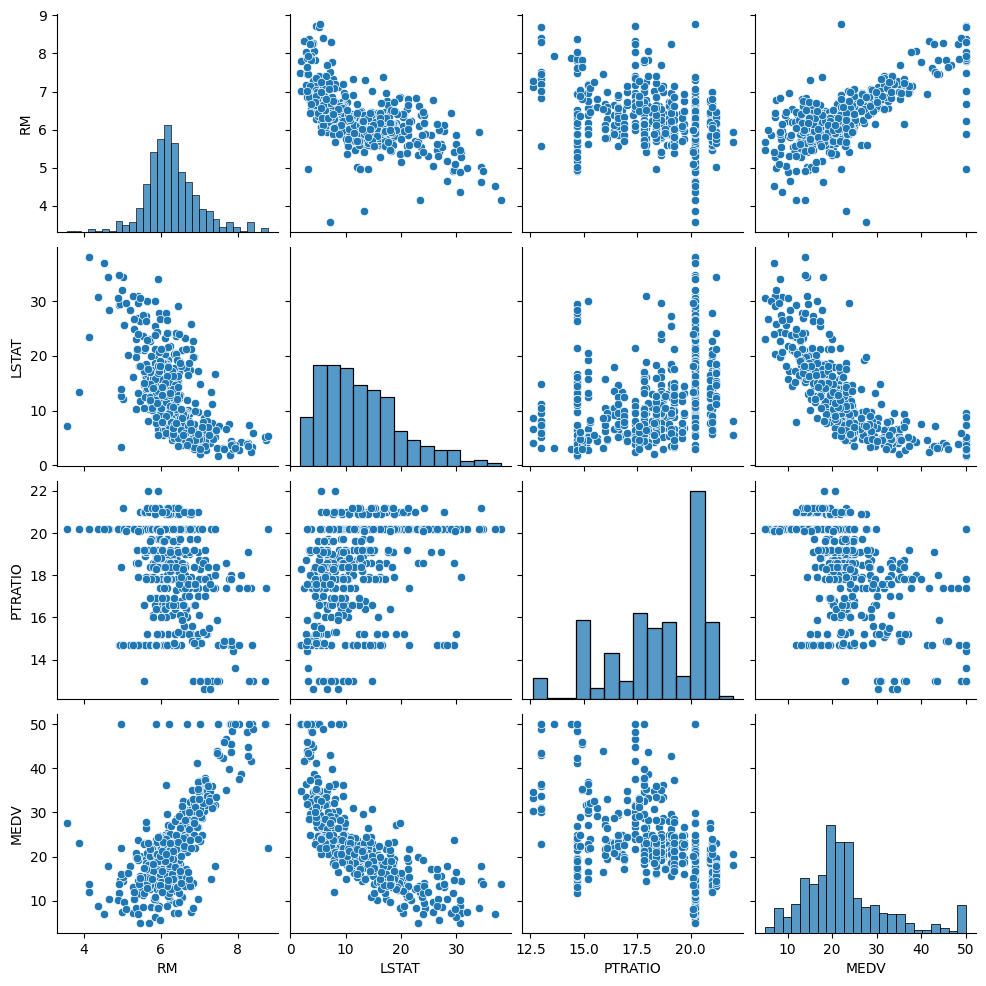

In [63]:
# Pairplot para visualizar relaciones entre variables y target
lista_variables_a_mostrar = ['RM', 'LSTAT', 'PTRATIO', 'MEDV']
sns.pairplot(df_boston[lista_variables_a_mostrar])

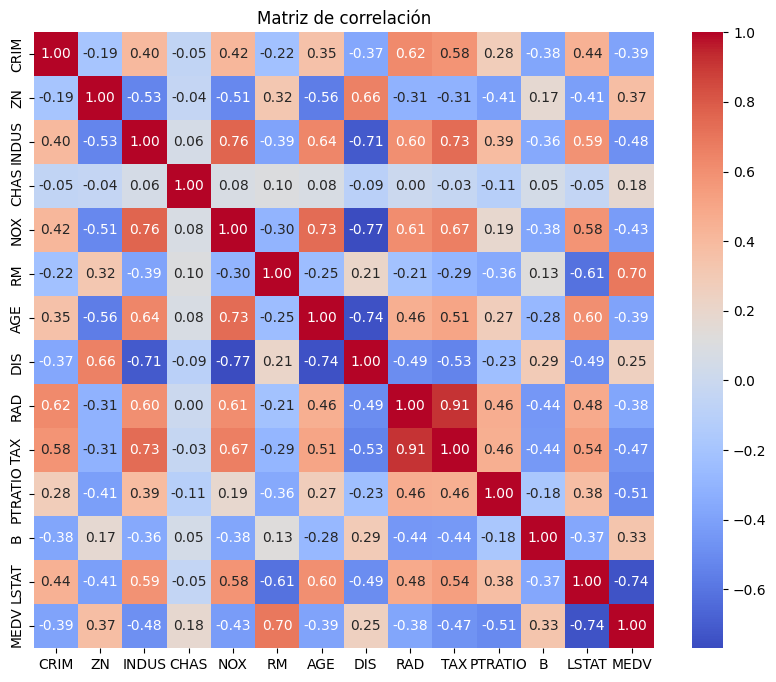

In [64]:
# Matriz de correlación y heatmap
corr = df_boston.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

In [65]:
df_boston.isna().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [66]:
# Gestionamos los valores faltantes o también llamados NaN
# Hay diversas opciones como eliminarlos, cambiarlos por un valor, etc
# Opta por la opción que mejor desees
df_boston_preprocessed = df_boston.dropna()

In [67]:
# Separamos las variables independientes (X) de la dependiente (Y)
X = df_boston_preprocessed.drop(columns="MEDV")# Variables independientes
y = df_boston_preprocessed["MEDV"]# Variable dependiente (target)

# Entrenamos un modelo de regresión lineal
modelo_boston = LinearRegression().fit(X, y)# continúa aquí

In [68]:
# Coeficientes del modelo
coeficientes_boston = modelo_boston.coef_
intercepto_boston = modelo_boston.intercept_
print("\nCoeficientes del modelo de regresión lineal:")
for i in range(len(X.columns)):
    print(f"Coeficiente para {X.columns[i]}: {coeficientes_boston[i]:.4f}")
print(f"Intercepto: {intercepto_boston:.4f}")


Coeficientes del modelo de regresión lineal:
Coeficiente para CRIM: -0.0976
Coeficiente para ZN: 0.0489
Coeficiente para INDUS: 0.0304
Coeficiente para CHAS: 2.7694
Coeficiente para NOX: -17.9690
Coeficiente para RM: 4.2833
Coeficiente para AGE: -0.0130
Coeficiente para DIS: -1.4585
Coeficiente para RAD: 0.2859
Coeficiente para TAX: -0.0131
Coeficiente para PTRATIO: -0.9146
Coeficiente para B: 0.0097
Coeficiente para LSTAT: -0.4237
Intercepto: 32.6801


In [69]:
# Fórmula del modelo
formula_boston = f"MEDV = {intercepto_boston:.4f} + " + " + ".join([f"{coef:.4f} * {col}" for coef, col in zip(coeficientes_boston, X.columns)])
print(f"\nFórmula del modelo de regresión lineal: {formula_boston}")


Fórmula del modelo de regresión lineal: MEDV = 32.6801 + -0.0976 * CRIM + 0.0489 * ZN + 0.0304 * INDUS + 2.7694 * CHAS + -17.9690 * NOX + 4.2833 * RM + -0.0130 * AGE + -1.4585 * DIS + 0.2859 * RAD + -0.0131 * TAX + -0.9146 * PTRATIO + 0.0097 * B + -0.4237 * LSTAT


In [70]:
# Predicciones y evaluación del modelo
y_pred = modelo_boston.predict(X)# Hacer el predict del modelo
_, _, _, _ = calcular_metricas_evaluacion(y_pred, y)


Evaluación del modelo:
MSE (Error cuadrático medio): 19.4184
RMSE (Raíz del error cuadrático medio): 4.4066
MAE (Error absoluto medio): 3.0644
R² (Coeficiente de determinación): 0.7671
El modelo explica aproximadamente el 76.71% de la varianza


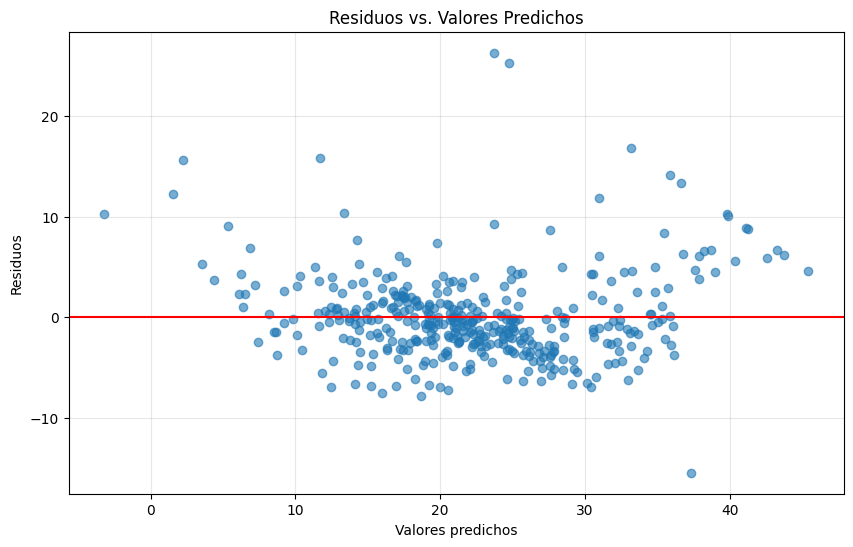

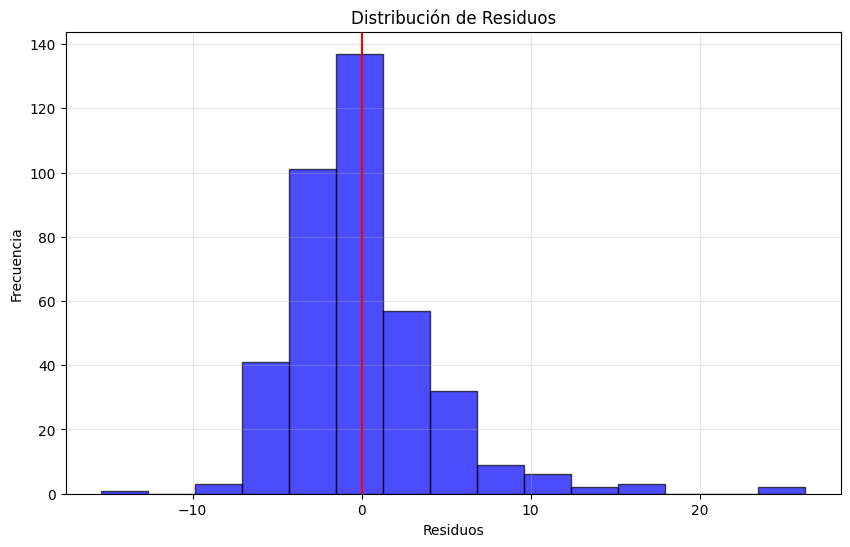

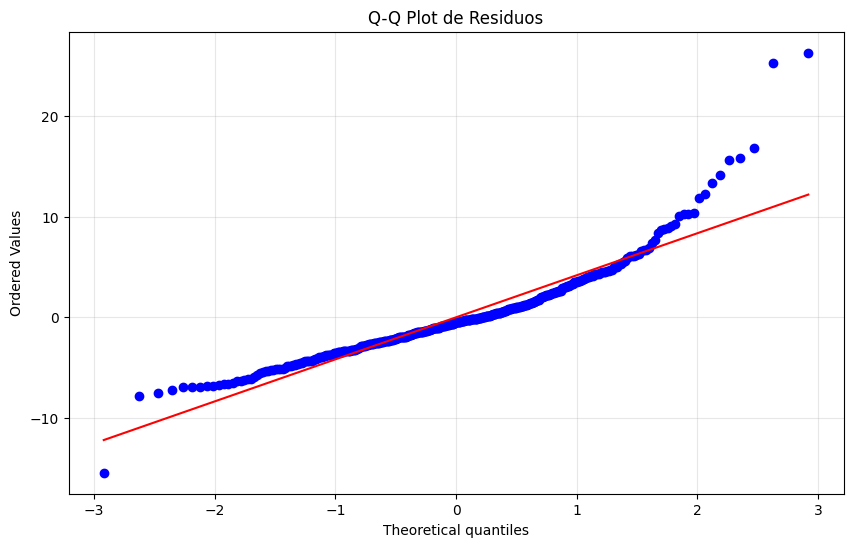

Resumen estadístico de los residuos:
Media: -0.0000
Desviación estándar: 4.4122
Mínimo: -15.4234
Máximo: 26.2604


In [71]:
# Visualización de residuos
plot_residuos(y_pred=y_pred, y_true=y)
plot_histograma_residuos(y_pred=y_pred, y_true=y)
plot_qq_plot_residuos(y_pred=y_pred, y_true=y)
# Resumen estadístico de residuos
resumen_estadistico_boston = resumen_estadistico_residuos(y_pred=y_pred, y_true=y, verbose=True)

## 3. Validación Hold-out (Train-split): Regresión Lineal Múltiple

<center><img src="../img/tecnicas_seleccion/tsl_particion.png" alt="Train-split" width="600"/></center>

Importante importar el método `train_test_split` de la librería sklearn:

```python
from sklearn.model_selection import train_test_split
```

In [ ]:
# Dividimos el dataframe en dos conjuntos, uno llamado train y otro de prueba (o test)
# Cada uno con sus variables independientes y dependiente
X_train, X_test, y_train, y_test = train_test_split(X, y

# Entrenamos sólo el modelo con el conjunto de entrenamiento

# Usamos las variables del conjunto de prueba (o test) para predecir


In [ ]:
# Calculamos las métricas de evaluación para el conjunto de entrenamiento

_, _, _, _ = calcular_metricas_evaluacion(y_pred, y_train)

# Calculamos las métricas de evaluación para el conjunto de prueba

_, _, _, _ = calcular_metricas_evaluacion(y_pred, y_test)

In [ ]:
# Visualización de residuos
plot_residuos(y_pred=y_pred, y_true=y_test)
plot_histograma_residuos(y_pred=y_pred, y_true=y_test)
plot_qq_plot_residuos(y_pred=y_pred, y_true=y_test)
# Resumen estadístico de residuos
resumen_estadistico_boston = resumen_estadistico_residuos(y_pred=y_pred, y_true=y_test, verbose=True)

## 4. Validación Cruzada (Cross Validation): Regresión Lineal Múltiple

<center><img src="../img/tecnicas_seleccion/tsl_cv.png" alt="Cross Validation" width="600"/></center>

Utilizar el método `cross_val_score` de `sklearn`

```python
from sklearn.model_selection import cross_val_score
```

In [72]:
# Instanciamos una variable con la clase de LinearRegression
# y ejecutamos la función de la validación cruzada
modelo_cv = LinearRegression()

In [73]:
# Vemos los diferentes scores para la métrica que hemos utilizado
score = cross_val_score(modelo_cv, X, y, cv=5, scoring="r2")

In [74]:
score

array([ 0.62919616,  0.76711271,  0.5857182 ,  0.0989904 , -0.16125209])

In [75]:
# Podemos aplicar diferentes estadísticos como la media
score.mean()

0.38395307612065127

### Ejercicio: Validación Cruzada sobre conjunto de datos de entrenamiento
Aplicar una validación cruzada pero sobre el conjunto de datos de entrenamiento como se muestra en la imagen:
<center><img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt"Cross validation search parameters" /></center>

In [83]:
# Hacer los siguientes pasos:
#    1. Generar un train-split al 20% con un random_state de 42 (como hemos hecho en los anteriores ejercicios)
#    2. Instanciar un modelo de regresión lineal
#    3. Aplicar la función de validación cruzada SÓLO CON EL CONJUNTO DE DATOS DE ENTRENAMIENTO (TRAIN)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_cv_trainset = LinearRegression()
scores = cross_val_score(modelo_cv_trainset, X_train, y_train, cv=5, scoring="r2")

In [84]:
scores.mean()

0.7501124201363728

In [85]:
modelo_cv.fit(X_train, y_train)
y_pred_cv = modelo_cv.predict(X_test)
_, _, _, _ = calcular_metricas_evaluacion(y_pred_cv, y_test)


Evaluación del modelo:
MSE (Error cuadrático medio): 31.4540
RMSE (Raíz del error cuadrático medio): 5.6084
MAE (Error absoluto medio): 3.3680
R² (Coeficiente de determinación): 0.6271
El modelo explica aproximadamente el 62.71% de la varianza


## 5. Regularización
Será necesario importar las siguientes clases de `sklearn`:

```python
from sklearn.linear_model import Ridge, Lasso
```

### 5.0 Infra-ajuste vs Sobre-ajuste (Underfitting vs Overfitting) de un modelo
Comparativa entre diferentes ajustes de ditintos modelos, sobre todo cuando los datos pueden no ser lineales como sería la relación entre el número de habitaciones y el precio medio del inmueble

In [86]:
X = df_boston[["RM"]]
y = df_boston["MEDV"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
# Underfitting: modelo lineal
modelo_underfitted = LinearRegression()
modelo_underfitted.fit(X_train, y_train)

# Calculamos las métricas de evaluación para el conjunto de prueba
y_pred = modelo_underfitted.predict(X_test)
_, _, _, _ = calcular_metricas_evaluacion(y_pred, y_test)


Evaluación del modelo:
MSE (Error cuadrático medio): 46.1448
RMSE (Raíz del error cuadrático medio): 6.7930
MAE (Error absoluto medio): 4.4783
R² (Coeficiente de determinación): 0.3708
El modelo explica aproximadamente el 37.08% de la varianza


In [88]:
# Modelo bien ajustado: polinomio grado 2
poly2 = PolynomialFeatures(degree=2)
X_poly2_train = poly2.fit_transform(X_train)
X_poly2_test = poly2.transform(X_test)

modelo_ajustado = LinearRegression()
modelo_ajustado.fit(X_poly2_train, y_train)

# Calculamos las métricas de evaluación para el conjunto de prueba
y_pred = modelo_ajustado.predict(X_poly2_test)
_, _, _, _ = calcular_metricas_evaluacion(y_pred, y_test)


Evaluación del modelo:
MSE (Error cuadrático medio): 35.3698
RMSE (Raíz del error cuadrático medio): 5.9472
MAE (Error absoluto medio): 4.1580
R² (Coeficiente de determinación): 0.5177
El modelo explica aproximadamente el 51.77% de la varianza


In [89]:
# Overfitting: polinomio grado 15
poly15 = PolynomialFeatures(degree=15)
X_poly15_train = poly15.fit_transform(X_train)
X_poly15_test = poly15.transform(X_test)

modelo_overfitted = LinearRegression()
modelo_overfitted.fit(X_poly15_train, y_train)

# Calculamos las métricas de evaluación para el conjunto de prueba
y_pred = modelo_overfitted.predict(X_poly15_test)
_, _, _, _ = calcular_metricas_evaluacion(y_pred, y_test)


Evaluación del modelo:
MSE (Error cuadrático medio): 35.0480
RMSE (Raíz del error cuadrático medio): 5.9201
MAE (Error absoluto medio): 4.0426
R² (Coeficiente de determinación): 0.5221
El modelo explica aproximadamente el 52.21% de la varianza


C:\Users\gaizk\OneDrive\Escritorio\Gaizka\master\Pontia\05 - Machine Learning y Deep Learning\pontia_modulo_ml_alumnos\env-pontia-ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\gaizk\OneDrive\Escritorio\Gaizka\master\Pontia\05 - Machine Learning y Deep Learning\pontia_modulo_ml_alumnos\env-pontia-ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names

C:\Users\gaizk\OneDrive\Escritorio\Gaizka\master\Pontia\05 - Machine Learning y Deep Learning\pontia_modulo_ml_alumnos\env-pontia-ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names



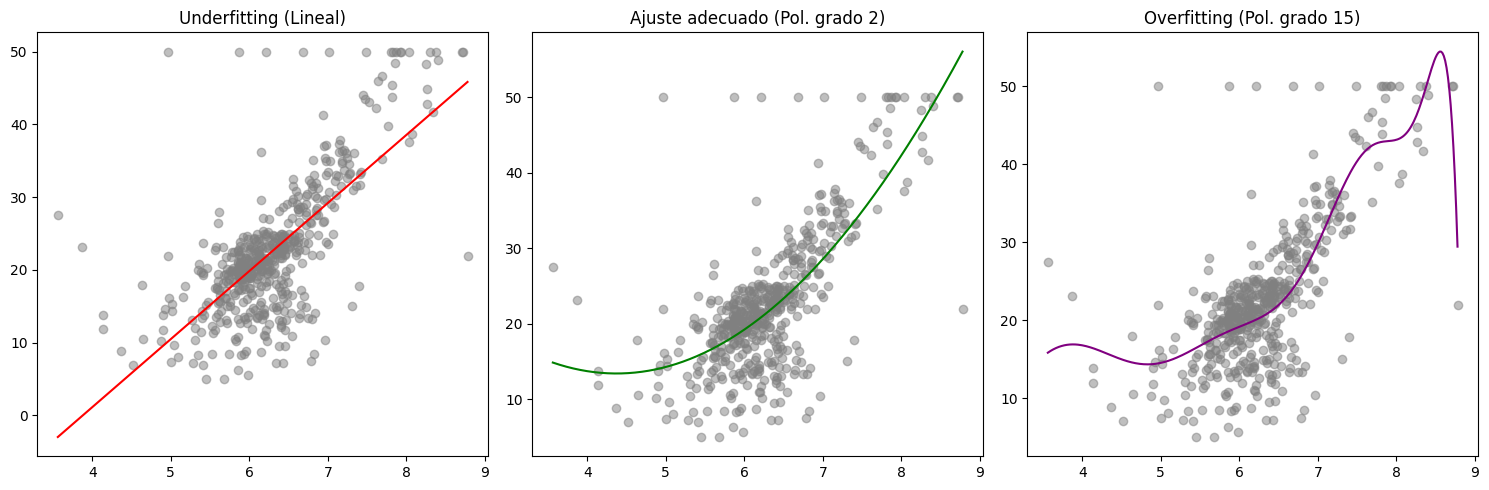

In [90]:
# Rango para graficar
X_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)

# Predicciones
y_pred_lr = modelo_underfitted.predict(X_range)
y_pred_lr2 = modelo_ajustado.predict(poly2.transform(X_range))
y_pred_lr15 = modelo_overfitted.predict(poly15.transform(X_range))

# Graficar
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X, y, color="gray", alpha=0.5)
plt.plot(X_range, y_pred_lr, color="red")
plt.title("Underfitting (Lineal)")

plt.subplot(1, 3, 2)
plt.scatter(X, y, color="gray", alpha=0.5)
plt.plot(X_range, y_pred_lr2, color="green")
plt.title("Ajuste adecuado (Pol. grado 2)")

plt.subplot(1, 3, 3)
plt.scatter(X, y, color="gray", alpha=0.5)
plt.plot(X_range, y_pred_lr15, color="purple")
plt.title("Overfitting (Pol. grado 15)")

plt.tight_layout()
plt.show()

### 5.1 Regularización Lasso L1

In [91]:
X = df_boston_preprocessed.drop(columns='MEDV')  # Variables independientes
y = df_boston_preprocessed['MEDV']  # Variable dependiente (target)

In [93]:
# Entrenamos un modelo con Lasso para un alpha de 0.1
alpha = 0.1
modelo_lasso = Lasso(alpha=alpha)
modelo_lasso.fit(X, y)

Lasso(alpha=0.1)

In [94]:
y_pred_lasso = modelo_lasso.predict(X)

In [96]:
_, _, _, _ = calcular_metricas_evaluacion(y_pred_lasso, y)


Evaluación del modelo:
MSE (Error cuadrático medio): 20.5234
RMSE (Raíz del error cuadrático medio): 4.5303
MAE (Error absoluto medio): 3.1123
R² (Coeficiente de determinación): 0.7539
El modelo explica aproximadamente el 75.39% de la varianza


In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
# Entrenamos un modelo con Lasso para un alpha de 0.1
alpha = 0.1
modelo_lasso = Lasso(alpha=alpha)
modelo_lasso.fit(X_train_lasso, y_train_lasso)

Lasso(alpha=0.1)

In [101]:
y_pred_lasso = modelo_lasso.predict(X_test)

In [103]:
# Calculamos las métricas de evaluación para el conjunto de entrenamiento
y_pred_lasso = modelo_lasso.predict(X_train)
_, _, _, _ = calcular_metricas_evaluacion(y_pred_lasso, y_train)

# Calculamos las métricas de evaluación para el conjunto de prueba
y_pred_lasso = modelo_lasso.predict(X_test)
_, _, _, _ = calcular_metricas_evaluacion(y_pred_lasso, y_test)


Evaluación del modelo:
MSE (Error cuadrático medio): 17.7488
RMSE (Raíz del error cuadrático medio): 4.2129
MAE (Error absoluto medio): 2.9993
R² (Coeficiente de determinación): 0.7848
El modelo explica aproximadamente el 78.48% de la varianza

Evaluación del modelo:
MSE (Error cuadrático medio): 33.7334
RMSE (Raíz del error cuadrático medio): 5.8080
MAE (Error absoluto medio): 3.4712
R² (Coeficiente de determinación): 0.6001
El modelo explica aproximadamente el 60.01% de la varianza


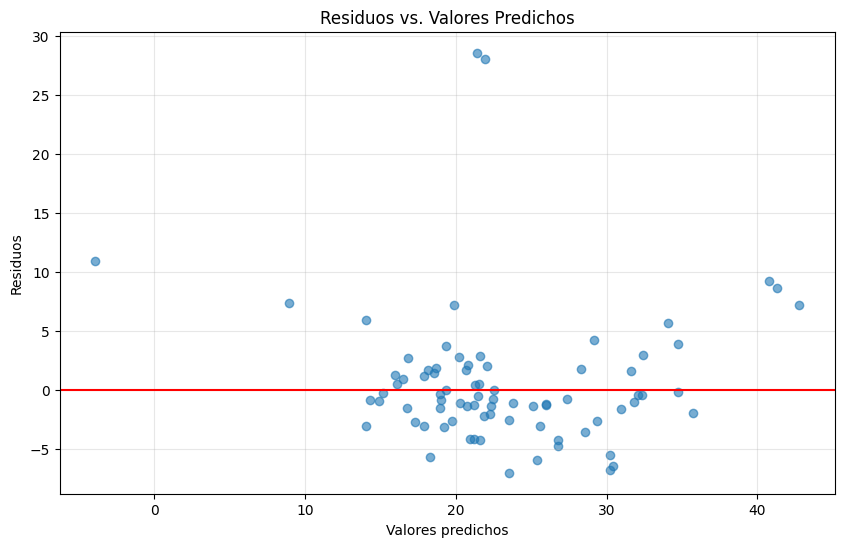

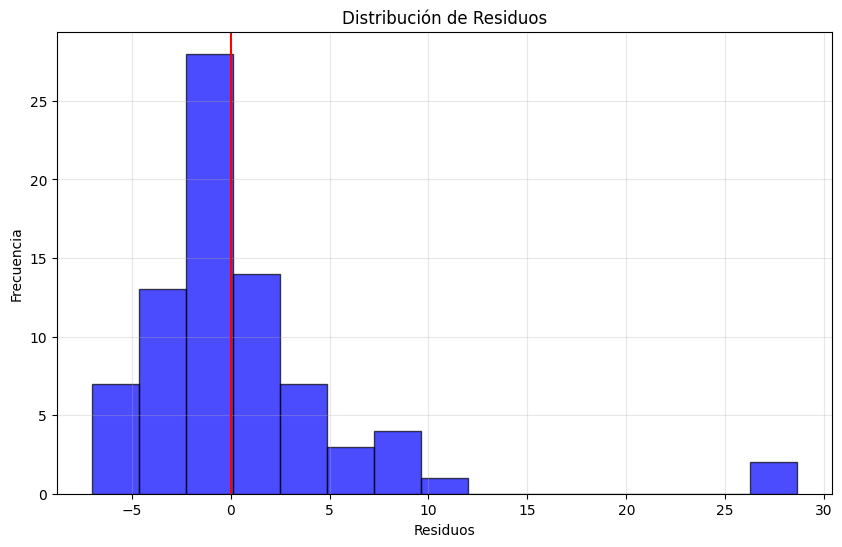

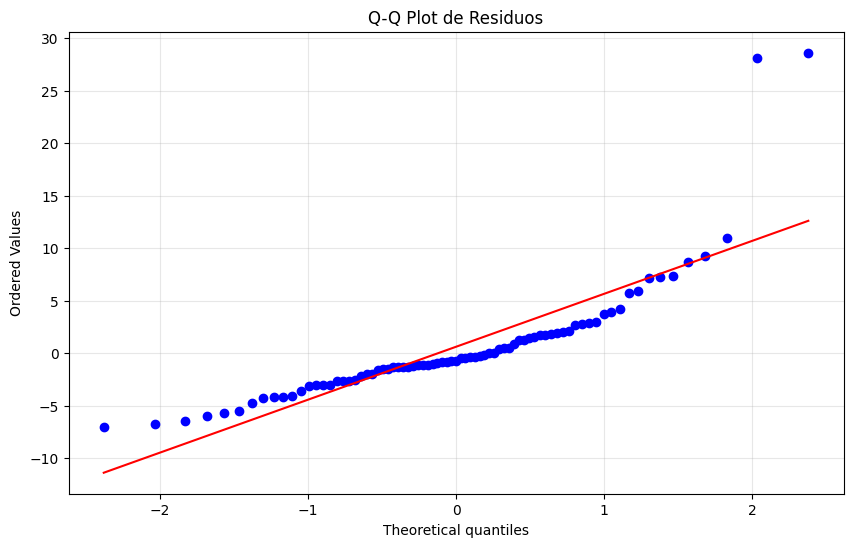

Resumen estadístico de los residuos:
Media: 0.6211
Desviación estándar: 5.8116
Mínimo: -7.0015
Máximo: 28.6127


In [104]:
# Visualización de residuos
plot_residuos(y_pred=y_pred_lasso, y_true=y_test)
plot_histograma_residuos(y_pred=y_pred_lasso, y_true=y_test)
plot_qq_plot_residuos(y_pred=y_pred_lasso, y_true=y_test)
# Resumen estadístico de residuos
resumen_estadistico_boston = resumen_estadistico_residuos(y_pred=y_pred_lasso, y_true=y_test, verbose=True)

### 5.2 Regularización Ridge L2

In [105]:
# Entrenamos un modelo usando Ridge con un alpha 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_ridge = Ridge(alpha=0.1)
modelo_ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [106]:
# Calculamos las métricas de evaluación para el conjunto de entrenamiento
y_pred_ridge = modelo_ridge.predict(X_train)
_, _, _, _ = calcular_metricas_evaluacion(y_pred_ridge, y_train)

# Calculamos las métricas de evaluación para el conjunto de prueba
y_pred_ridge = modelo_ridge.predict(X_test)
_, _, _, _ = calcular_metricas_evaluacion(y_pred_ridge, y_test)


Evaluación del modelo:
MSE (Error cuadrático medio): 16.7002
RMSE (Raíz del error cuadrático medio): 4.0866
MAE (Error absoluto medio): 2.9553
R² (Coeficiente de determinación): 0.7975
El modelo explica aproximadamente el 79.75% de la varianza

Evaluación del modelo:
MSE (Error cuadrático medio): 31.5248
RMSE (Raíz del error cuadrático medio): 5.6147
MAE (Error absoluto medio): 3.3657
R² (Coeficiente de determinación): 0.6262
El modelo explica aproximadamente el 62.62% de la varianza


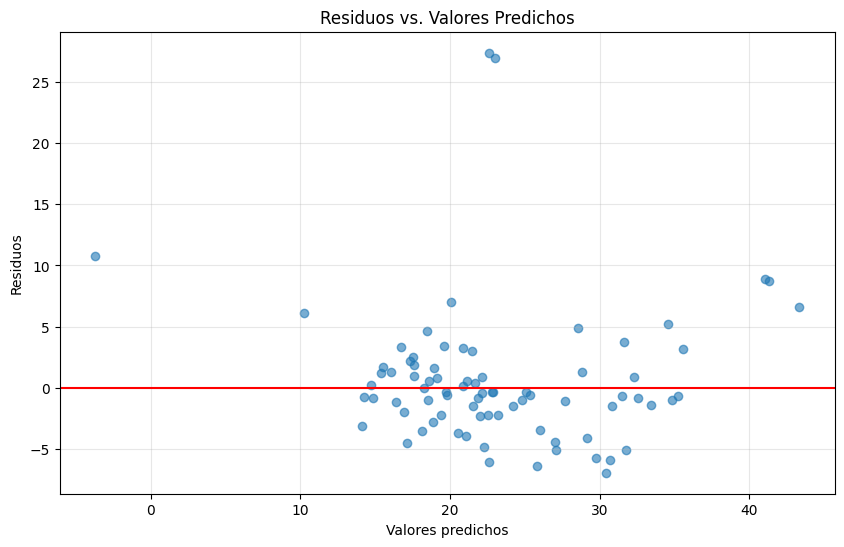

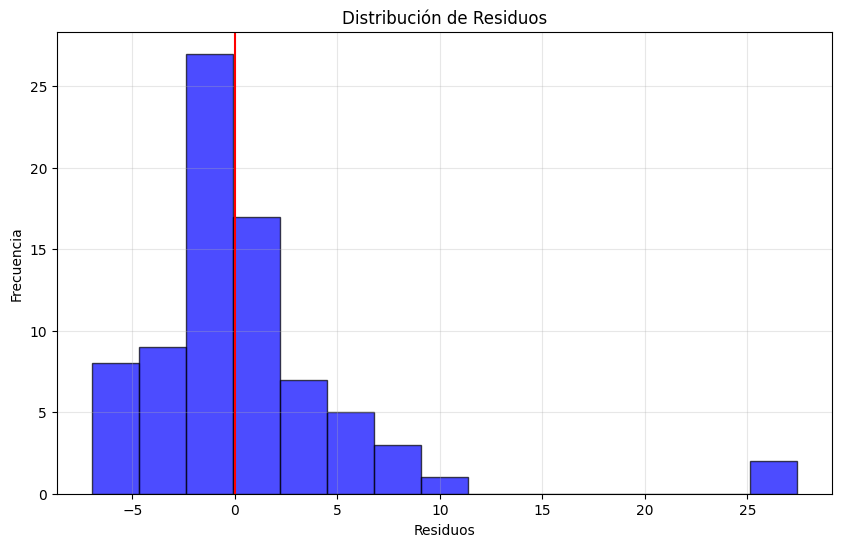

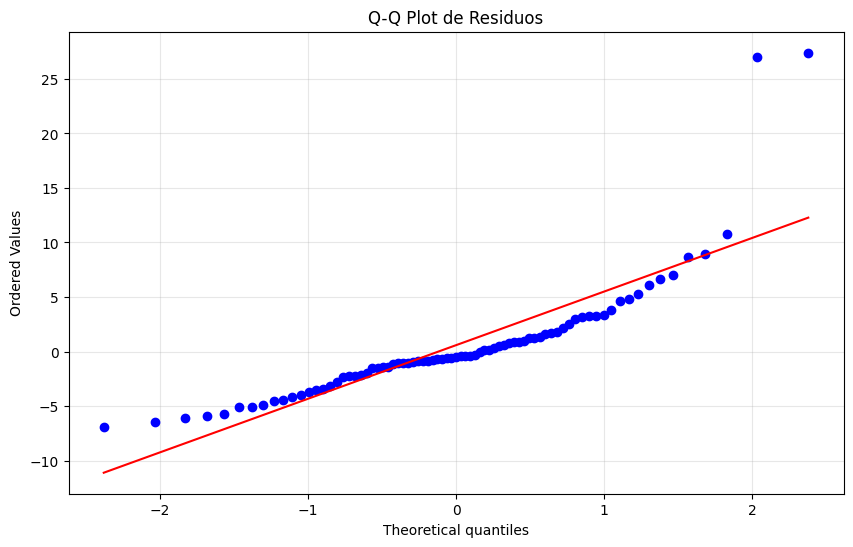

Resumen estadístico de los residuos:
Media: 0.5822
Desviación estándar: 5.6201
Mínimo: -6.9569
Máximo: 27.4000


In [107]:
# Visualización de residuos
plot_residuos(y_pred=y_pred_ridge, y_true=y_test)
plot_histograma_residuos(y_pred=y_pred_ridge, y_true=y_test)
plot_qq_plot_residuos(y_pred=y_pred_ridge, y_true=y_test)
# Resumen estadístico de residuos
resumen_estadistico_boston = resumen_estadistico_residuos(y_pred=y_pred_ridge, y_true=y_test, verbose=True)

### Ejercicio: Utilizar otro parámetro `alpha` con Lasso y Ridge

In [113]:
# Utilizar los siguientes alphas y entrenar un modelo de Lasso con cada una de ellas y también un modelo de Ridge
alphas = [0.01, 0.1, 1.0, 5.0]
dict_resultados = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for a in alphas:
    
    modelo_ridge = Ridge(alpha=a)
    modelo_ridge.fit(X_train, y_train)
    y_pred_ridge = modelo_ridge.predict(X_test)
    dict_resultados.append(calcular_metricas_evaluacion(y_pred_ridge, y_test))


Evaluación del modelo:
MSE (Error cuadrático medio): 31.4612
RMSE (Raíz del error cuadrático medio): 5.6090
MAE (Error absoluto medio): 3.3676
R² (Coeficiente de determinación): 0.6270
El modelo explica aproximadamente el 62.70% de la varianza

Evaluación del modelo:
MSE (Error cuadrático medio): 31.5248
RMSE (Raíz del error cuadrático medio): 5.6147
MAE (Error absoluto medio): 3.3657
R² (Coeficiente de determinación): 0.6262
El modelo explica aproximadamente el 62.62% de la varianza

Evaluación del modelo:
MSE (Error cuadrático medio): 31.9924
RMSE (Raíz del error cuadrático medio): 5.6562
MAE (Error absoluto medio): 3.3634
R² (Coeficiente de determinación): 0.6207
El modelo explica aproximadamente el 62.07% de la varianza

Evaluación del modelo:
MSE (Error cuadrático medio): 32.6496
RMSE (Raíz del error cuadrático medio): 5.7140
MAE (Error absoluto medio): 3.4091
R² (Coeficiente de determinación): 0.6129
El modelo explica aproximadamente el 61.29% de la varianza


In [114]:
dict_resultados

[(31.461179904826846,
  5.609026645045185,
  3.3675785929825803,
  0.6270004352799136),
 (31.52479356388472,
  5.6146944319245655,
  3.3657063465751373,
  0.6262462401985269),
 (31.99239484575457, 5.65618200253091, 3.3633637094196533, 0.6207024215900823),
 (32.6496465926042, 5.713986926184221, 3.4091222392245273, 0.6129101322917136)]

In [115]:
pd.DataFrame(dict_resultados)

,0,1,2,3
0,31.461180,5.609027,3.367579,0.627000
1,31.524794,5.614694,3.365706,0.626246
2,31.992395,5.656182,3.363364,0.620702
3,32.649647,5.713987,3.409122,0.612910


## 6. Ajuste de hiperparámetros
Es una manera automática de no tener que hacer un bucle o probar a mano para detectar cuál es la mejor combinación de hiperparámetros.

Importar la librería `GridSearch`:

```python
from sklearn.model_selection import GridSearchCV
```

In [116]:
X = df_boston_preprocessed.drop(columns='MEDV')  # Variables independientes
y = df_boston_preprocessed['MEDV']  # Variable dependiente (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
# Instanciar un modelo de Ridge y tomar el listado de valores de alpha definidos a continuación
model_ridge = Ridge()

# Crear una matriz con los hiperparámetros necesarios que queremos probar
dict_hyperparams = {
    "alpha": [0.01, 0.1, 0.2, 5]
}


# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model_ridge, param_grid=dict_hyperparams, cv=5, scoring="r2")

# Ejecutar la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), param_grid={'alpha': [0.01, 0.1, 0.2, 5]},
             scoring='r2')

In [118]:
# Mostrar los mejores hiperparámetros encontrados
print(f"Mejor alpha: {grid_search.best_params_}")
print(f"Mejor alpha: {grid_search.best_score_}")

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba



Mejor alpha: {'alpha': 0.1}
Mejor alpha: 0.7503430988487276
